In [1]:
import cv2
import glob
import numpy as np
import os
from PIL import Image
import random
import time
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import DataLoader, random_split
from torchvision.models import vgg19
from turbojpeg import TurboJPEG #disable this if dependency is not ready or not all image are JPEG

/home/nakere424/miniconda3/envs/anime_inpaint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
#These function return 0,1 2D mask where 1 is masked area
def create_mask(mask_width, mask_length, brush_amount = 1):
    mask = np.zeros((mask_width, mask_length), dtype = 'uint8')
    
    for brush in range(brush_amount):
        num_vertices = np.random.randint(1,12)
        start_x = np.random.randint(0, mask_length)
        start_y = np.random.randint(0, mask_width)
        brush_thickness = np.random.randint(5,30)
        positive_move_x, negative_move_x, positive_move_y, negative_move_y = 0, 0, 0, 0

        for i in range(num_vertices):
            angle = random.uniform(0, 2*np.pi)
            if i%2 == 0:
                angle = angle + random.uniform((7*np.pi)/8, (9*np.pi)/8)

            length = random.uniform(1, mask_length/12)
            
            if positive_move_x:
                end_x = round(start_x + np.abs(length*np.cos(angle)))
            elif negative_move_x:
                end_x = round(start_x - np.abs(length*np.cos(angle)))
            else:
                end_x = round(start_x + length*np.cos(angle))
            
            if positive_move_y:
                end_y = round(start_y + np.abs(length*np.sin(angle)))
            elif negative_move_y:
                end_y = round(start_y - np.abs(length*np.sin(angle)))
            else:
                end_y = round(start_y + length*np.sin(angle))
            
            positive_move_x, negative_move_x, positive_move_y, negative_move_y = 0, 0, 0, 0
            
            end_x = max(end_x, 0)
            end_x = min(end_x, mask_length)
            end_y = max(end_y, 0)
            end_y = min(end_y, mask_width)
            
            #For prevent moving out of edge again
            if end_x == 0:
                positive_move_x = 1
            if end_x == mask_length:
                negative_move_x = 1
            if end_y == 0:
                positive_move_y = 1
            if end_y == mask_width:
                negative_move_y = 1
            
            cv2.circle(mask, (start_x, start_y), round(brush_thickness/2), 255, -1)
            cv2.line(mask, (start_x, start_y), (end_x,end_y), 255, brush_thickness)

            start_x = end_x
            start_y = end_y
        
        cv2.circle(mask, (start_x, start_y), round(brush_thickness/2), 255, -1)
    
    horizon_flip = random.choice([0, 1])
    vertical_flip = random.choice([0, 1])
    
    if horizon_flip:
        mask = cv2.flip(mask, 1)
    if vertical_flip:
        mask = cv2.flip(mask, 0)
    
    mask[mask>0] = 1
        
    return mask

def create_large_mask(mask_width, mask_length, brush_amount = 1):
    mask = np.zeros((mask_width, mask_length), dtype = 'uint8')
    
    for brush in range(brush_amount):
        num_vertices = np.random.randint(4,12)
        start_x = np.random.randint(0, mask_length)
        start_y = np.random.randint(0, mask_width)
        brush_thickness = np.random.randint(12,40)
        positive_move_x, negative_move_x, positive_move_y, negative_move_y = 0, 0, 0, 0

        for i in range(num_vertices):
            angle = (2*np.pi)/5 + random.uniform(random.uniform(-(2*np.pi)/15, 0), random.uniform(0, (2*np.pi)/15))
            if i%2 == 0:
                angle = 2*np.pi - angle

            length = np.random.normal(mask_length/8, mask_length/16)
            
            if positive_move_x:
                end_x = round(start_x + np.abs(length*np.cos(angle)))
            elif negative_move_x:
                end_x = round(start_x - np.abs(length*np.cos(angle)))
            else:
                end_x = round(start_x + length*np.cos(angle))
            
            if positive_move_y:
                end_y = round(start_y + np.abs(length*np.sin(angle)))
            elif negative_move_y:
                end_y = round(start_y - np.abs(length*np.sin(angle)))
            else:
                end_y = round(start_y + length*np.sin(angle))
            
            positive_move_x, negative_move_x, positive_move_y, negative_move_y = 0, 0, 0, 0
            
            end_x = max(end_x, 0)
            end_x = min(end_x, mask_length)
            end_y = max(end_y, 0)
            end_y = min(end_y, mask_width)
            
            #For prevent moving out of edge again
            if end_x == 0:
                positive_move_x = 1
            if end_x == mask_length:
                negative_move_x = 1
            if end_y == 0:
                positive_move_y = 1
            if end_y == mask_width:
                negative_move_y = 1
                
            cv2.circle(mask, (start_x, start_y), round(brush_thickness/2), 255, -1)
            cv2.line(mask, (start_x,start_y), (end_x,end_y), 256, brush_thickness)
            
            start_x, start_y = end_x, end_y
        
        cv2.circle(mask, (start_x, start_y), round(brush_thickness/2), 255, -1)
        
    horizon_flip = random.choice([0, 1])
    vertical_flip = random.choice([0, 1])
    
    if horizon_flip:
        mask = cv2.flip(mask, 1)
    if vertical_flip:
        mask = cv2.flip(mask, 0)
    
    mask[mask>0] = 1
        
    return mask

In [24]:
#For 3D image only, return masked image and 3D mask
def mask_image(image_array, mask_type = 1, brush_amount = 1):
    mask_width, mask_length = image_array.shape[0], image_array.shape[1]
    
    if mask_type == 1:
        mask = create_mask(mask_width, mask_length, brush_amount)
    elif mask_type == 2:
        mask = create_large_mask(mask_width, mask_length, brush_amount)
    else:
        raise Exception("mask_type must be either 1 or 2")
    
    mask_3D = np.repeat(np.expand_dims(mask, 2), 3, 2)
    
    masked_image = (1-mask_3D) * image_array
    
    return masked_image, mask_3D

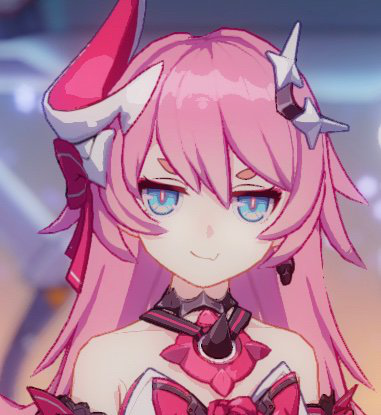

In [25]:
rozaliya = Image.open(r'/home/nakere424/anime_inpainting/5be4592e2c46a4291af915a5a0306ce57cbf2d6dr1-381-415v2_00.jpg')
rozaliya

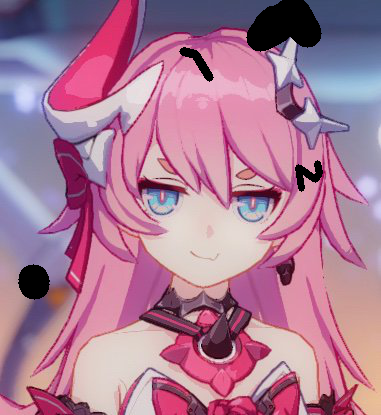

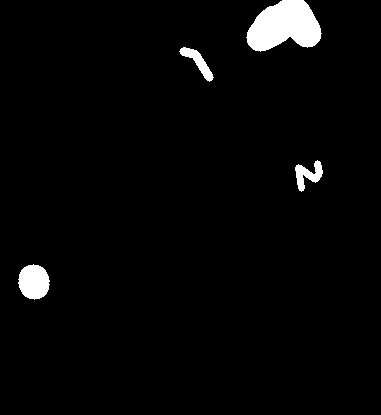

In [26]:
masked_rozaliya, mask = mask_image(np.array(rozaliya), 1, 4)
masked_rozaliya = Image.fromarray(masked_rozaliya)
display(masked_rozaliya)
mask[mask>0] = 255 #For visualize
mask = Image.fromarray(mask)
display(mask)

In [27]:
class GateConv2d(nn.Module):
    def __init__(self, conv_in_channels, conv_out_channels, kernel_size, stride = 1, padding = 'same', dilation=1):
        #Important! conv_out_channel is output channel of convolution layer not output of entire gate convolution
        super(GateConv2d, self).__init__()
        self.conv = nn.Conv2d(conv_in_channels, conv_out_channels, kernel_size, stride, padding, dilation)
        self.BatchNorm2d = nn.BatchNorm2d(conv_out_channels//2)
        self.BatchNorm2d_3channels = nn.BatchNorm2d(3)
        self.ELU = nn.ELU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv(x)
        
        if x.shape[1] == 3:
            output = self.BatchNorm2d_3channels(x)
            return output
        
        feature, gating = x[:, :x.shape[1]//2, :, :], x[:, x.shape[1]//2:, :, :] #split channels into 2
        
        feature = self.ELU(feature)
        gating = self.Sigmoid(gating)
        
        output = feature * gating
        output = self.BatchNorm2d(output)
        
        return output

In [28]:
GateConv2d_debug = GateConv2d(conv_in_channels = 6, conv_out_channels = 64, kernel_size = 3, padding = 1)

rozaliya = cv2.resize(np.array(rozaliya), (256, 256))
masked_rozaliya, mask = mask_image(np.array(rozaliya), 1, 4)
mask_rozaliya = torch.tensor(masked_rozaliya, dtype = torch.float32)
mask = torch.tensor(mask, dtype = torch.float32)
x = torch.unsqueeze(torch.permute(torch.cat((mask_rozaliya, mask), dim = 2), (2, 0, 1)), 0)

start = time.time()
print(f'GateConv2d \ninput_shape : {x.shape}, output_shape: {GateConv2d_debug(x).shape}')
end = time.time()
print(f'Use time : {end - start}')

GateConv2d 
input_shape : torch.Size([1, 6, 256, 256]), output_shape: torch.Size([1, 32, 256, 256])
Use time : 0.012232065200805664


In [29]:
class ResidualGateBlock(nn.Module):
    def __init__(self, conv_in_channels, conv_out_channels, gate_amount):
        super(ResidualGateBlock, self).__init__()
        
        layers = []
        
        layers.append(GateConv2d(conv_in_channels, conv_out_channels, 3))
        for i in range(1, gate_amount):
            layers.append(GateConv2d(conv_out_channels//2, conv_out_channels, 3))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.block[0](x)
        residual = x.clone()
        
        for i in range(1, len(self.block)):
            x = self.block[i](x)
        
        output = x + residual
        
        return output

class DilationResidualGateBlock(nn.Module):
    def __init__(self, conv_in_channels, conv_out_channels, gate_amount, dilation_list):
        super(DilationResidualGateBlock, self).__init__()
        
        layers = []
        
        layers.append(GateConv2d(conv_in_channels, conv_out_channels, 3, padding = dilation_list[0]
                                 , dilation = dilation_list[0]))
        for i in range(1, gate_amount):
            layers.append(GateConv2d(conv_out_channels//2, conv_out_channels, 3, padding = dilation_list[i]
                                     , dilation = dilation_list[i]))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.block[0](x)
        residual = x.clone()
        
        for i in range(1, len(self.block)):
            x = self.block[i](x)
        
        output = x + residual
        
        return output

In [30]:
ResidualGateBlock_debug = ResidualGateBlock(6, 64, 3)

start = time.time()
print(f'ResidualGateBlock \ninput_shape : {x.shape}, output_shape: {ResidualGateBlock_debug(x).shape}')
end = time.time()
print(f'Use time : {end - start}')

ResidualGateBlock 
input_shape : torch.Size([1, 6, 256, 256]), output_shape: torch.Size([1, 32, 256, 256])
Use time : 0.05783414840698242


In [31]:
class CoarseNet(nn.Module):
    def __init__(self):
        super(CoarseNet, self).__init__()
        self.encoder_block1 = ResidualGateBlock(6, 64, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block2 = ResidualGateBlock(32, 128, 3)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.bottleneck_block = DilationResidualGateBlock(64, 256, 3, [2,4,8])
        self.upsample1 = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.decoder_block1 = ResidualGateBlock(128, 128, 4)
        self.upsample2 = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.decoder_block2 = ResidualGateBlock(64, 64, 4)
        self.last_layer = GateConv2d(32, 3, 3)
    
    def forward(self, masked_image, mask):
        
        x = torch.cat((masked_image, mask), dim = 1) #Shape batch x 6 x W x H
        
        x = self.encoder_block1(x)
        x = self.maxpool1(x)
        x = self.encoder_block2(x)
        x = self.maxpool2(x)
        x = self.bottleneck_block(x)
        x = self.upsample1(x)
        x = self.decoder_block1(x)
        x = self.upsample2(x)
        x = self.decoder_block2(x)
        output = self.last_layer(x) #Shape batch x 3 x W x H
        
        return output

In [32]:
CoarseNet_debug = CoarseNet()
masked_image = x[:,:3,:,:]
mask = x[:,3:,:,:]

start = time.time()
print(f'ResidualGateBlock \ninput_shape : {x.shape}, output_shape: {CoarseNet_debug(masked_image, mask).shape}')
end = time.time()
print(f'Use time : {end - start}')

ResidualGateBlock 
input_shape : torch.Size([1, 6, 256, 256]), output_shape: torch.Size([1, 3, 256, 256])
Use time : 0.3221883773803711


In [33]:
#For check amount of parameters
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
print(f'CoarseNet parameters amount : {count_parameters(CoarseNet_debug)}')

CoarseNet parameters amount : 1427921


In [35]:
def random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y : y + crop_height, x : x + crop_width]

    return crop

def preprocess(array):
        
    tensor = torch.as_tensor(array, dtype = torch.float32)
    tensor = torch.permute(tensor, (2, 0, 1))
    tensor = (tensor-127.5) / 255.

    return tensor

#For training individual Coarse network only
class CoarseDataset:
    def __init__(self, path, mask_type):
        self.path = path
        self.image_name_list = os.listdir(path)
        self.mask_type = mask_type
        
    def __len__(self):
        return len(self.image_name_list)

    def __getitem__(self, index):
        image_name = self.image_name_list[index]
        image_path = self.path + '/' + image_name
        # original_image = cv2.imread(image_path)
        jpeg = TurboJPEG()
        in_file = open(image_path, 'rb')
        original_image = jpeg.decode(in_file.read())
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        
        groundtruth = random_crop(original_image, 256, 256) 
        
        if self.mask_type == 1:
            brush_amount = round(random.uniform(1, 6)) #Subject to be change
            
        elif self.mask_type == 2:
            brush_amount = round(random.uniform(1, 4)) #Subject to be change
        
        else:
            raise Exception("mask_type must be either 1 or 2")
        
        masked_image, mask = mask_image(groundtruth, mask_type = self.mask_type, brush_amount = brush_amount)
        
        masked_image = preprocess(masked_image)
        mask = torch.permute(torch.tensor(mask, dtype = torch.float32), (2, 0, 1))
        groundtruth = preprocess(groundtruth)
        
        return masked_image, mask, groundtruth

In [36]:
def l1_loss(predict, groundtruth):
    output = torch.abs(predict - groundtruth)
    output = torch.mean(output)
    return output

def vgg_loss(predict, groundtruth, vgg_model):
    predict_vgg = vgg_model(predict)
    groundtruth_vgg = vgg_model(groundtruth)
    
    output = torch.abs(predict_vgg - groundtruth_vgg)
    output = torch.mean(output)
    return output

def coarse_loss(predict, groundtruth, vgg_model, vgg_loss_weight = 0.01):
    return l1_loss(predict, groundtruth) + vgg_loss_weight*vgg_loss(predict, groundtruth, vgg_model)

In [37]:
vgg19_model = vgg19(weights = 'IMAGENET1K_V1')
vgg19_model = vgg19_model.features[:21]

for param in vgg19_model.parameters():
    param.requires_grad = False
    
original_image = torch.unsqueeze(torch.permute(torch.tensor(np.array(rozaliya), dtype = torch.float32), (2, 0, 1)), 0)

coarse_loss(original_image, masked_image + mask*CoarseNet_debug(masked_image, mask), vgg19_model)

tensor(9.0249, grad_fn=<AddBackward0>)

In [38]:
#For training individual Coarse network only
def fit_coarse(coarse_model, vgg19_model, epochs, optimizer, accumulation_step, train_dataloader, val_dataloader = None, 
               save_model_path = None, load_model_path = None):
    if load_model_path is not None:
        coarse_model = coarse_model.load_state_dict(torch.load(load_model_path))
    
    device = 'cuda' #Use GPU for train, please install CUDA and CuDNN
    torch.backends.cudnn.benchmark = True
    use_amp = True
    
    train_dataloader.use_gpu = True
    
    coarse_model = coarse_model.to(device)
    vgg19_model = vgg19_model.to(device)
    
    scaler = torch.cuda.amp.GradScaler(enabled = use_amp)
    
    print(f'Training coarse network')
    
    for epoch in range(epochs):
        print(f'epoch : {epoch+1}')
        
        train_size = len(train_dataloader.dataset)
        num_batches = len(train_dataloader)
        train_loss = 0
        
        for batch, (masked_image, mask, groundtruth) in enumerate(train_dataloader):
            
            masked_image, mask, groundtruth = masked_image.to(device), mask.to(device), groundtruth.to(device)
            with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp): #AMP optimize training time
                coarse_output = coarse_model(masked_image, mask)
                
                output = (mask*coarse_output) + masked_image
                
                loss = coarse_loss(output, groundtruth, vgg19_model)
                train_loss += loss
                loss /= accumulation_step

            scaler.scale(loss).backward(inputs = list(coarse_model.parameters()))
            
            if (batch + 1) % accumulation_step == 0:
                scaler.step(optimizer)
                scaler.update()
                coarse_model.zero_grad(set_to_none=True)

            if batch % 20 == 0:
                loss, current = loss.item() * accumulation_step, batch * len(groundtruth)
                print(f"loss: {loss:>4f}  [{current:>6d}/{train_size:>6d}]")
            
        train_loss /= num_batches
        print(f"Average train loss: {train_loss:>4f}")
        
        if val_dataloader is not None:
            val_size = len(val_dataloader.dataset)
            num_batches = len(val_dataloader)
            val_loss = 0
            
            val_dataloader.use_gpu = True

            with torch.no_grad():
                for masked_image, mask, groundtruth in val_dataloader:
                    masked_image, mask, groundtruth = masked_image.to(device), mask.to(device), groundtruth.to(device)
                    
                    with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp):
                        coarse_output = coarse_model(masked_image, mask)
                        
                        output = (mask*coarse_output) + masked_image
                        
                        loss = coarse_loss(output, groundtruth, vgg19_model)
                        val_loss += loss
                    
            val_loss /= num_batches
            print(f"Validation Loss: \nAvg loss: {val_loss:>8f} \n")
    
        if save_model_path is not None and ((100 * (epoch + 1)) / epochs) % 10 == 0:
            torch.save(coarse_model.state_dict(), os.path.join(save_model_path, 'coarse_model_' + str(epoch + 1)  + '.pt'))

In [39]:
!nvidia-smi

Tue Jan  3 20:19:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.03    Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     9W /  N/A |   3667MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
vgg19_model = vgg19(weights = 'IMAGENET1K_V1')
vgg19_model = vgg19_model.features[:21]

epochs = 10
learning_rate = 1e-05
batch_size = 8
accumulation_step = 1

coarse_model = CoarseNet()
optimizer = torch.optim.AdamW(coarse_model.parameters(), lr = learning_rate)

coarse_dataset = CoarseDataset('/home/nakere424/anime_inpainting/Image', 1)
coarse_dataloader = DataLoader(coarse_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = True)

In [41]:
start = time.time()
fit_coarse(coarse_model, vgg19_model, epochs, optimizer, accumulation_step, coarse_dataloader)
end = time.time()
print(f'train time : {end - start : >4f}')

Training coarse network
epoch : 1
loss: 0.102198  [     0/     8]
Average train loss: 0.102198
epoch : 2
loss: 0.068309  [     0/     8]
Average train loss: 0.068309
epoch : 3
loss: 0.094010  [     0/     8]
Average train loss: 0.094010
epoch : 4
loss: 0.074240  [     0/     8]
Average train loss: 0.074240
epoch : 5
loss: 0.073328  [     0/     8]
Average train loss: 0.073328
epoch : 6
loss: 0.075865  [     0/     8]
Average train loss: 0.075865
epoch : 7
loss: 0.088767  [     0/     8]
Average train loss: 0.088767
epoch : 8
loss: 0.060306  [     0/     8]
Average train loss: 0.060306
epoch : 9
loss: 0.056832  [     0/     8]
Average train loss: 0.056832
epoch : 10
loss: 0.062144  [     0/     8]
Average train loss: 0.062144
train time : 6.722175


In [42]:
def postprocess(tensor):
    assert len(tensor.shape) == 4
    
    output = torch.permute(tensor, (0, 2, 3, 1))
    output = (255.*output) + 127.5
    output = np.array(output, dtype = 'uint8')
    return output

In [43]:
with torch.no_grad():
    for masked_image, mask, groundtruth in coarse_dataloader:
        masked_image, mask, groundtruth = masked_image.to('cuda'), mask.to('cuda'), groundtruth.to('cuda')
        output = (mask*coarse_model(masked_image, mask)) + masked_image
        masked_image = postprocess(masked_image.cpu())
        output = postprocess(output.cpu())
        groundtruth = postprocess(groundtruth.cpu())

output.shape

(8, 256, 256, 3)

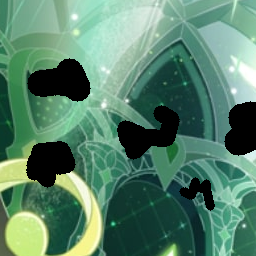

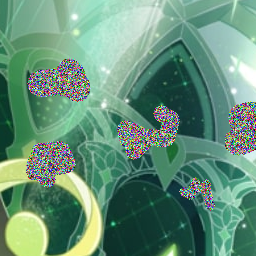

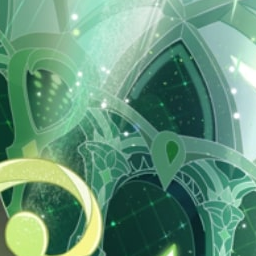

In [44]:
sample_masked_image = Image.fromarray(masked_image[5])
display(sample_masked_image)
sample_output = Image.fromarray(output[5])
display(sample_output)
sample_groundtruth = Image.fromarray(groundtruth[5])
display(sample_groundtruth)

In [45]:
class SuperResolutionResidualBlock(nn.Module):
    def __init__(self):
        super(SuperResolutionResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1, bias = False), nn.ReLU(), nn.BatchNorm2d(64))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1, bias = False), nn.ReLU(), nn.BatchNorm2d(64))
    
    def forward(self, x):
        residual = x.clone()
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        output = x + residual
        
        return output

In [46]:
block_input = torch.rand((8, 64, 256, 256))
SuperResolutionResidualBlock_debug = SuperResolutionResidualBlock()

start = time.time()
print(f'SuperResulutionResidualBlock \ninput_shape : {block_input.shape}, output_shape: {SuperResolutionResidualBlock_debug(block_input).shape}')
end = time.time()
print(f'Use time : {end - start}')

SuperResulutionResidualBlock 
input_shape : torch.Size([8, 64, 256, 256]), output_shape: torch.Size([8, 64, 256, 256])
Use time : 0.4491887092590332


In [47]:
class SuperResolutionNet(nn.Module):
    def __init__(self):
        super(SuperResolutionNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, 1, 1, bias = False), nn.ReLU(), nn.BatchNorm2d(64))
        self.block1 = SuperResolutionResidualBlock()
        self.block2 = SuperResolutionResidualBlock()
        self.block3 = SuperResolutionResidualBlock()
        self.block4 = SuperResolutionResidualBlock()
        self.conv2 = nn.Sequential(nn.Conv2d(64, 256, 3, 1, 1, bias = False), nn.ReLU(), nn.BatchNorm2d(256))
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.conv3 = nn.Sequential(nn.Conv2d(64, 3, 3, 1, 1, bias = False), nn.ReLU(), nn.BatchNorm2d(3))
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bicubic')
        
    def forward(self, x):
        global_residual = x.clone() #Shape batch x 3 x W x H
        global_residual = self.upsample(global_residual) #Shape batch x 3 x 2W x 2H
        
        x = self.conv1(x) #Shape batch x 64 x W x H
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.conv2(x) #Shape batch x 256 x W x H
        x = self.pixel_shuffle(x) #Shape batch x 64 x 2W x 2H
        x = self.conv3(x) #Shape batch x 3 x 2W x 2H
        
        output = x + global_residual
        
        return output

In [48]:
super_resolution_input = torch.rand((8, 3, 256, 256))
SuperResolutionNet_debug = SuperResolutionNet()

start = time.time()
print(f'SuperResolutionNet \ninput_shape : {super_resolution_input.shape}, output_shape: {SuperResolutionNet_debug(super_resolution_input).shape}')
end = time.time()
print(f'Use time : {end - start}')

SuperResolutionNet 
input_shape : torch.Size([8, 3, 256, 256]), output_shape: torch.Size([8, 3, 512, 512])
Use time : 3.74767804145813


In [49]:
print(f'SuperResolutionNet parameters amount : {count_parameters(SuperResolutionNet_debug)}')

SuperResolutionNet parameters amount : 447494


In [50]:
#For training individual SuperResolution network only
class SuperResolutionDataset:
    def __init__(self, path):
        self.path = path
        self.image_name_list = os.listdir(path)
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, index):
        image_name = self.image_name_list[index]
        image_path = self.path + '/' + image_name
        # original_image = cv2.imread(image_path)
        jpeg = TurboJPEG()
        in_file = open(image_path, 'rb')
        original_image = jpeg.decode(in_file.read())
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        
        groundtruth = random_crop(original_image, 128, 128) #Randomly crop 128 x 128 image from original image 
                                                            #(Use for groundtruth in super resolution model)
        resize_image = cv2.resize(groundtruth, (64, 64))
        
        groundtruth, resize_image = preprocess(groundtruth), preprocess(resize_image)
        
        return resize_image, groundtruth

In [51]:
#For training individual Coarse network only
def fit_super_resolution(super_resolution_model, epochs, optimizer, accumulation_step, train_dataloader, 
                         val_dataloader = None, save_model_path = None, load_model_path = None):
    if load_model_path is not None:
        super_resolution_model = super_resolution_model.load_state_dict(torch.load(load_model_path))
    
    device = 'cuda' #Use GPU for train, please install CUDA and CuDNN
    torch.backends.cudnn.benchmark = True
    use_amp = True
    
    super_resolution_model = super_resolution_model.to(device)
    
    scaler = torch.cuda.amp.GradScaler(enabled = use_amp) 
    
    print(f'Training super resolution network')
    
    for epoch in range(epochs):
        print(f'epoch : {epoch+1}')
        
        train_size = len(train_dataloader.dataset)
        num_batches = len(train_dataloader)
        train_loss = 0
        
        for batch, (resize_image, groundtruth) in enumerate(train_dataloader):
            resize_image, groundtruth = resize_image.to(device), groundtruth.to(device)
            
            with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp): #AMP optimize training time
                output = super_resolution_model(resize_image)

                loss = l1_loss(output, groundtruth)
                train_loss += loss
                loss /= accumulation_step
            
            scaler.scale(loss).backward(inputs = list(super_resolution_model.parameters()))
            
            if (batch + 1) % accumulation_step == 0:
                scaler.step(optimizer)
                scaler.update()
                super_resolution_model.zero_grad(set_to_none=True)

            if batch % 20 == 0:
                loss, current = loss.item() * accumulation_step, batch * len(groundtruth)
                print(f"loss: {loss:>4f}  [{current:>6d}/{train_size:>6d}]")
            
        train_loss /= num_batches
        print(f"Average train loss: {train_loss:>4f}")
        
        if val_dataloader is not None:
            val_size = len(val_dataloader.dataset)
            num_batches = len(val_dataloader)
            val_loss = 0

            with torch.no_grad():
                for resize_image, groundtruth in val_dataloader:
                    resize_image, groundtruth = resize_image.to(device), groundtruth.to(device)
                    
                    with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp):
                        output = super_resolution_model(resize_image)
                        loss = l1_loss(output, groundtruth)
                        val_loss += loss
                    
            val_loss /= num_batches
            print(f"Validation Loss: \nAvg loss: {val_loss:>8f} \n")
    
        if save_model_path is not None and ((100 * (epoch + 1)) / epochs) % 10 == 0:
            torch.save(super_resolution_model.state_dict(), 
                       os.path.join(save_model_path, 'super_resolution_model_' + str(epoch + 1) + '.pt'))

In [52]:
epochs = 25
learning_rate = 1e-05
batch_size = 8
accumulation_step = 1

super_resolution_model = SuperResolutionNet()
optimizer = torch.optim.AdamW(super_resolution_model.parameters(), lr = learning_rate)

super_resolution_dataset = SuperResolutionDataset('/home/nakere424/anime_inpainting/Image')
super_resolution_dataloader = DataLoader(super_resolution_dataset, batch_size = batch_size, num_workers = 0, shuffle = True, pin_memory = True)

In [53]:
start = time.time()
fit_super_resolution(super_resolution_model, epochs, optimizer, accumulation_step, super_resolution_dataloader)
end = time.time()
print(f'train time : {end - start : >4f}')

Training super resolution network
epoch : 1
loss: 0.733957  [     0/     8]
Average train loss: 0.733957
epoch : 2
loss: 0.752499  [     0/     8]
Average train loss: 0.752499
epoch : 3
loss: 0.723538  [     0/     8]
Average train loss: 0.723538
epoch : 4
loss: 0.690284  [     0/     8]
Average train loss: 0.690284
epoch : 5
loss: 0.722528  [     0/     8]
Average train loss: 0.722528
epoch : 6
loss: 0.712859  [     0/     8]
Average train loss: 0.712859
epoch : 7
loss: 0.679244  [     0/     8]
Average train loss: 0.679244
epoch : 8
loss: 0.709523  [     0/     8]
Average train loss: 0.709523
epoch : 9
loss: 0.736596  [     0/     8]
Average train loss: 0.736596
epoch : 10
loss: 0.702835  [     0/     8]
Average train loss: 0.702835
epoch : 11
loss: 0.696223  [     0/     8]
Average train loss: 0.696223
epoch : 12
loss: 0.651274  [     0/     8]
Average train loss: 0.651274
epoch : 13
loss: 0.695469  [     0/     8]
Average train loss: 0.695469
epoch : 14
loss: 0.710052  [     0/    

In [54]:
def same_padding(tensor, kernel_size, stride, dilation):
    assert len(tensor.shape) == 4
    
    image_shape = tensor.shape # batch x channel x height x width
    
    output_height = (image_shape[2] + stride - 1) // stride
    output_width = (image_shape[3] + stride - 1) // stride
    
    padding_height = (stride*(output_height-1) - image_shape[2] + dilation * (kernel_size - 1) + 1) / 2
    padding_width = (stride*(output_width-1) - image_shape[3] + dilation * (kernel_size - 1) + 1) / 2
    
    padding_top = padding_bottom = max(round(padding_height), 0)
    padding_left = padding_right = max(round(padding_width), 0)
    
    padder = nn.ZeroPad2d((padding_left, padding_right, padding_top, padding_bottom))
    
    output = padder(tensor)
    
    return output

def pad_and_unfold(tensor, block_size, stride, dilation = 1, padding = 'same'):
    assert len(tensor.shape) == 4 and padding in ['same', 'valid']
    
    if padding == 'same':
        tensor = same_padding(tensor, block_size, stride, dilation) #Make number of block equal to tensor width x tensor height
    
    unfold = nn.Unfold(block_size, dilation, 0, stride)
    
    output = unfold(tensor)
    
    return output #Shape batch x no of numbers in each block x no of block(L)

def reduce_mean(tensor, axis, keepdim=False):
    for i in sorted(axis, reverse=True):
        tensor = torch.mean(tensor, dim=i, keepdim=keepdim)
        
    return tensor

def reduce_sum(tensor, axis, keepdim=False):
    for i in sorted(axis, reverse=True):
        tensor = torch.sum(tensor, dim=i, keepdim=keepdim)
        
    return tensor

In [55]:
class ContextualAttention(nn.Module):
    def __init__(self, block_size, stride, attention_rate, softmax_scale = 10, use_gpu = False):
        super(ContextualAttention, self).__init__()
        self.block_size = block_size
        self.stride = stride
        self.attention_rate = attention_rate
        self.softmax_scale = softmax_scale
        
        if use_gpu:
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        
    def forward(self, x, mask):
        x_shape = x.shape
        
        if mask.shape[2] != x.shape[2] or mask.shape[3] != x.shape[3]:
            mask = F.interpolate(mask, size = (x.shape[2], x.shape[3]))
        
        x_clone = x.clone()
        mask_clone = mask.clone()
        mask_clone = mask_clone[:, 1, :, :].unsqueeze(1)
        
        raw_x_block_size = 2*self.attention_rate
        
        x_unfold = pad_and_unfold(x, raw_x_block_size, self.attention_rate*self.stride) #Shape N x k*k*C x L
        x_unfold = x_unfold.view(x_shape[0], x_shape[1], raw_x_block_size, raw_x_block_size, -1) #Shape N x C x k x k x L
        x_unfold = torch.permute(x_unfold, (0, 4, 1, 2, 3)) #Shape N x L x C x k x k
        
        x_unfold_minibatch = torch.split(x_unfold, 1, dim=0) #Filter for devoncolve
        
        x_resize = F.interpolate(x, scale_factor=1./self.attention_rate, mode='nearest')
        x_resize_shape = x_resize.shape #Shape N x C x H/rate x W/rate
        
        x_resize_minibatch = torch.split(x_resize, 1, dim=0) #Input for convolve
        
        x_resize_unfold = pad_and_unfold(x_resize, self.block_size, self.stride)
        x_resize_unfold = x_resize_unfold.view(x_resize_shape[0], x_resize_shape[1], self.block_size, self.block_size, -1)
        x_resize_unfold = torch.permute(x_resize_unfold, (0, 4, 1, 2, 3))
        x_resize_unfold_minibatch = torch.split(x_resize_unfold, 1, dim=0) #Filter for convolve
        
        mask_resize = F.interpolate(mask, scale_factor=1./self.attention_rate, mode='nearest')
        mask_resize_shape = mask_resize.shape
        
        mask_resize_unfold = pad_and_unfold(mask_resize, self.block_size, self.stride)
        mask_resize_unfold = mask_resize_unfold.view(mask_resize_shape[0], mask_resize_shape[1], self.block_size, self.block_size, -1)
        mask_resize_unfold = torch.permute(mask_resize_unfold, (0, 4, 1, 2, 3))
        mask_resize_unfold_minibatch = torch.split(mask_resize_unfold, 1, dim=0) #For filter mask region
        
        output = []
        
        for x_input, x_filter, x_defilter, mask_filter in zip(x_resize_minibatch, x_resize_unfold_minibatch, x_unfold_minibatch, mask_resize_unfold_minibatch):
            x_filter = x_filter[0] #Shape L x C x k x k
            escape_nan = torch.FloatTensor([1e-4]).to(self.device)
            x_filter_normed = x_filter / torch.sqrt(reduce_sum(torch.pow(x_filter, 2) + escape_nan, axis=[1, 2, 3], keepdim=True))
            
            x_input = same_padding(x_input, self.block_size, 1, 1)
            
            attention = F.conv2d(x_input, x_filter_normed, stride=1) #Shape 1 x L x H/rate x W/rate
            attention = attention.view(1, x_resize_shape[2]*x_resize_shape[3], x_resize_shape[2], x_resize_shape[3]) #Shape 1 x H/rate*W/rate x H/rate x W/rate
                
            mask_filter = mask_filter[0] #Shape L x C x k x k
            mask_filter = (reduce_mean(mask_filter, axis=[1, 2, 3], keepdim=True)==0.).to(torch.float32)
            mask_filter = torch.permute(mask_filter, (1, 0, 2, 3)) #Shape 1 x L x 1 x 1
            
            masked_attention = attention * mask_filter
            masked_attention = F.softmax(masked_attention*self.softmax_scale, dim=1)
            masked_attention = masked_attention * mask_filter #Product softmax attention only for masked region
            
            x_defilter = x_defilter[0]
            
            output_i = F.conv_transpose2d(masked_attention, x_defilter, stride=self.attention_rate, padding=1)
            output.append(output_i)
            
        output = torch.cat(output, dim=0)
        output.contiguous().view(x_shape)
        
        output = mask_clone*output + (1-mask_clone)*x_clone
        
        return output

torch.Size([1, 3, 256, 256])
Use time : 2.530956745147705


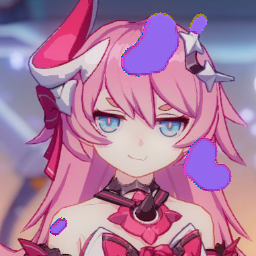

In [56]:
rozaliya = cv2.imread(r'/home/nakere424/anime_inpainting/5be4592e2c46a4291af915a5a0306ce57cbf2d6dr1-381-415v2_00.jpg')
rozaliya = cv2.cvtColor(rozaliya, cv2.COLOR_RGB2BGR)
rozaliya = cv2.resize(rozaliya, (256, 256))

masked_rozaliya, mask = mask_image(rozaliya, 1, 4)

masked_rozaliya, mask = preprocess(masked_rozaliya), torch.permute(torch.tensor(mask, dtype = torch.float32), (2, 0, 1))
masked_rozaliya, mask = torch.unsqueeze(masked_rozaliya, 0), torch.unsqueeze(mask, 0)

start = time.time()
ContextualAttention_debug = ContextualAttention(3, 1, 2)

output = ContextualAttention_debug(masked_rozaliya, mask)
print(f'{output.shape}')
end = time.time()
print(f'Use time : {end - start}')

output = Image.fromarray(postprocess(output)[0])
display(output)

In [57]:
class RefinementNet(nn.Module):
    def __init__(self, use_gpu = False):
        super(RefinementNet, self).__init__()
        self.encoder_block1 = ResidualGateBlock(6, 64, 3)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.encoder_block2 = ResidualGateBlock(32, 128, 3)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.bottleneck_block = DilationResidualGateBlock(64, 256, 3, [2,4,8])
        self.gate1 = GateConv2d(128, 256, 3)
        self.contexual_attetion = ContextualAttention(3, 1, 2, 10, use_gpu)
        self.gate2 = GateConv2d(128, 256, 3)
        #Concat output of bottleneck and attention
        self.upsample1 = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.decoder_block1 = ResidualGateBlock(256, 128, 4)
        self.upsample2 = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.decoder_block2 = ResidualGateBlock(64, 64, 4)
        self.last_layer = GateConv2d(32, 3, 3)
    
    def forward(self, masked_image, mask):
        x = torch.cat((masked_image, mask), dim = 1) #Shape batch x 6 x W x H
        
        x = self.encoder_block1(x)
        x = self.maxpool1(x)
        x = self.encoder_block2(x)
        x = self.maxpool2(x)
        x = self.bottleneck_block(x)
        bottleneck_output = x.clone() #Shape batch x 128 x W/4 x H/4
        
        x = self.gate1(x)
        x = self.contexual_attetion(x, mask)
        x = self.gate2(x)
        x = torch.cat((bottleneck_output, x), dim = 1) #Shape batch x 256 x W/4 x H/4
        
        x = self.upsample1(x)
        x = self.decoder_block1(x)
        x = self.upsample2(x)
        x = self.decoder_block2(x)
        output = self.last_layer(x) #Shape batch x 3 x W x H
        
        return output

In [58]:
RefinementNet_debug = RefinementNet()

start = time.time()
output = RefinementNet_debug(masked_rozaliya, mask)
print(f'{output.shape}')
end = time.time()
print(f'Use time : {end - start}')

torch.Size([1, 3, 256, 256])
Use time : 0.8497109413146973


In [59]:
print(f'RefinementNet parameters amount : {count_parameters(RefinementNet_debug)}')

RefinementNet parameters amount : 2166237


In [60]:
#For training individual RefinementNet network only
class RefinementDataset:
    def __init__(self, path, mask_type):
        self.path = path
        self.image_name_list = os.listdir(path)
        self.mask_type = mask_type
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, index):
        image_name = self.image_name_list[index]
        image_path = self.path + '/' + image_name
        # original_image = cv2.imread(image_path)
        jpeg = TurboJPEG()
        in_file = open(image_path, 'rb')
        original_image = jpeg.decode(in_file.read())
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        
        groundtruth = random_crop(original_image, 256, 256) #Random crop 256 x 256
        
        if self.mask_type == 1:
            brush_amount = round(random.uniform(1, 6)) #Subject to be change
            
        elif self.mask_type == 2:
            brush_amount = round(random.uniform(1, 4)) #Subject to be change
        
        else:
            raise Exception("mask_type must be either 1 or 2")
        
        masked_image, mask = mask_image(groundtruth, mask_type = self.mask_type, brush_amount = brush_amount)
        
        masked_image = preprocess(masked_image)
        mask = torch.permute(torch.tensor(mask, dtype = torch.float32), (2, 0, 1))
        groundtruth = preprocess(groundtruth)
        
        return masked_image, mask, groundtruth

In [61]:
#For training individual RefinementNet network only
def fit_refinement(refinement_model, vgg19_model, epochs, optimizer, accumulation_step, train_dataloader, val_dataloader = None, 
               save_model_path = None, load_model_path = None):
    if load_model_path is not None:
        refinement_model = refinement_model.load_state_dict(torch.load(load_model_path))
    
    device = 'cuda' #Use GPU for train, please install CUDA and CuDNN
    torch.backends.cudnn.benchmark = True
    use_amp = True
    
    refinement_model = refinement_model.to(device)
    vgg19_model = vgg19_model.to(device)
    
    scaler = torch.cuda.amp.GradScaler(enabled = use_amp) 
    
    print(f'Training refinement network')
    
    for epoch in range(epochs):
        print(f'epoch : {epoch+1}')
        
        train_size = len(train_dataloader.dataset)
        num_batches = len(train_dataloader)
        train_loss = 0
        
        for batch, (masked_image, mask, groundtruth) in enumerate(train_dataloader):
            masked_image, mask, groundtruth = masked_image.to(device), mask.to(device), groundtruth.to(device)
            
            with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp): #AMP optimize training time
                refinement_output = refinement_model(masked_image, mask)
                
                output = (mask*refinement_output) + (1-mask)*groundtruth

                loss = coarse_loss(output, groundtruth, vgg19_model) #use same loss as coarse when train individual
                train_loss += loss
                loss /= accumulation_step
            
            scaler.scale(loss).backward(inputs = list(refinement_model.parameters()))
            
            if (batch + 1) % accumulation_step == 0:
                scaler.step(optimizer)
                scaler.update()
                refinement_model.zero_grad(set_to_none=True)

            if batch % 20 == 0:
                loss, current = loss.item() * accumulation_step, batch * len(groundtruth)
                print(f"loss: {loss:>4f}  [{current:>6d}/{train_size:>6d}]")
            
        train_loss /= num_batches
        print(f"Average train loss: {train_loss:>4f}")
        
        if val_dataloader is not None:
            val_size = len(val_dataloader.dataset)
            num_batches = len(val_dataloader)
            val_loss = 0

            with torch.no_grad():
                for masked_image, mask, groundtruth in val_dataloader:
                    masked_image, mask, groundtruth = masked_image.to(device), mask.to(device), groundtruth.to(device)
                    
                    with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp):
                        refinement_output = refinement_model(masked_image, mask)
                        
                        output = (mask*refinement_output) + (1-mask)*groundtruth
                        
                        loss = coarse_loss(output, groundtruth, vgg19_model)  #Same loss as coarse
                        val_loss += loss
                    
            val_loss /= num_batches
            print(f"Validation Loss: \nAvg loss: {val_loss:>8f} \n")
    
        if save_model_path is not None and ((100 * (epoch + 1)) / epochs) % 10 == 0:
            torch.save(refinement_model.state_dict(), os.path.join(save_model_path, 'refinement_model_' + str(epoch + 1)  + '.pt'))

In [62]:
vgg19_model = vgg19(weights = 'IMAGENET1K_V1')
vgg19_model = vgg19_model.features[:21]

epochs = 10
learning_rate = 1e-05
batch_size = 8
accumulation_step = 1

refinement_model = RefinementNet(use_gpu = True)
optimizer = torch.optim.AdamW(refinement_model.parameters(), lr = learning_rate)

refinement_dataset = RefinementDataset('/home/nakere424/anime_inpainting/Image', 1)
refinement_dataloader = DataLoader(refinement_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = True)

In [63]:
start = time.time()
fit_refinement(refinement_model, vgg19_model, epochs, optimizer, accumulation_step, refinement_dataloader)
end = time.time()
print(f'train time : {end - start : >4f}')

Training refinement network
epoch : 1
loss: 0.081624  [     0/     8]
Average train loss: 0.081624
epoch : 2
loss: 0.068898  [     0/     8]
Average train loss: 0.068898
epoch : 3
loss: 0.093881  [     0/     8]
Average train loss: 0.093881
epoch : 4
loss: 0.095711  [     0/     8]
Average train loss: 0.095711
epoch : 5
loss: 0.067972  [     0/     8]
Average train loss: 0.067972
epoch : 6
loss: 0.070718  [     0/     8]
Average train loss: 0.070718
epoch : 7
loss: 0.076866  [     0/     8]
Average train loss: 0.076866
epoch : 8
loss: 0.077460  [     0/     8]
Average train loss: 0.077460
epoch : 9
loss: 0.072153  [     0/     8]
Average train loss: 0.072153
epoch : 10
loss: 0.077680  [     0/     8]
Average train loss: 0.077680
train time : 8.323874


In [64]:
with torch.no_grad():
    for masked_image, mask, groundtruth in refinement_dataloader:
        masked_image, mask, groundtruth = masked_image.to('cuda'), mask.to('cuda'), groundtruth.to('cuda')
        output = refinement_model(masked_image, mask)
        output = mask*output + (1-mask)*groundtruth
        masked_image = postprocess(masked_image.cpu())
        output = postprocess(output.cpu())
        groundtruth = postprocess(groundtruth.cpu())

output.shape

(8, 256, 256, 3)

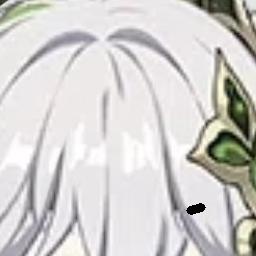

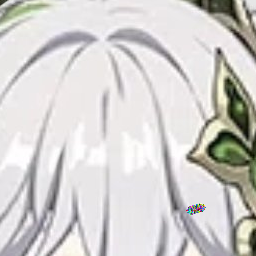

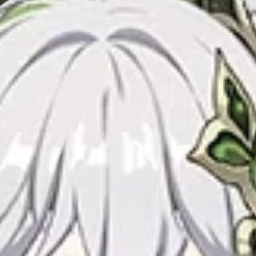

In [65]:
sample_masked_image = Image.fromarray(masked_image[3])
display(sample_masked_image)
sample_output = Image.fromarray(output[3])
display(sample_output)
sample_groundtruth = Image.fromarray(groundtruth[3])
display(sample_groundtruth)

In [66]:
def individual_fit(network, epochs, batch_size, accumulation_step, train_image_path, val_image_path = None, 
               save_model_path = None, load_model_path = None):
    assert network in ['coarse', 'super_resolution', 'refinement']
    assert type(epochs) == int and epochs > 0
    
    vgg19_model = vgg19(weights = 'IMAGENET1K_V1')
    vgg19_model = vgg19_model.features[:21]
    
    coarse_valloader = super_resolution_valloader = refinement_valloader = None #Assign to None first and may change later
    
    if network == 'coarse':
        coarse_model = CoarseNet()
        coarse_trainset = CoarseDataset(train_image_path, 1)
        coarse_trainloader = DataLoader(coarse_trainset, batch_size = batch_size, 
                                               shuffle = True, pin_memory = True)
        
        if val_image_path is not None:
            coarse_valset = CoarseDataset(val_image_path, 1)
            coarse_valloader = DataLoader(coarse_valset, batch_size = batch_size, 
                                               shuffle = False, pin_memory = True)
        
        optimizer = torch.optim.AdamW(coarse_model.parameters(), lr = 1e-5)
        
        fit_coarse(coarse_model, vgg19_model, epochs, optimizer, accumulation_step, coarse_trainloader, coarse_valloader,
                  save_model_path, load_model_path)
    
    elif network == 'super_resolution':
        super_resolution_model = SuperResolutionNet()
        super_resolution_trainset = SuperResolutionDataset(train_image_path)
        super_resolution_trainloader = DataLoader(super_resolution_trainset, batch_size = batch_size, 
                                                 shuffle = True, pin_memory = True)
        
        if val_image_path is not None:
            super_resolution_valset = SuperResolutionDataset(val_image_path)
            super_resolution_valloader = DataLoader(super_resolution_valset, batch_size = batch_size, 
                                                 shuffle = False, pin_memory = True)
        
        optimizer = torch.optim.AdamW(super_resolution_model.parameters(), lr = 1e-5)
        
        fit_super_resolution(super_resolution_model, epochs, optimizer, accumulation_step, super_resolution_trainloader,
                            super_resolution_valloader, save_model_path, load_model_path)
    
    else:
        refinement_model = RefinementNet(use_gpu = True)
        refinement_trainset = RefinementDataset(train_image_path, 1)
        refinement_trainloader = DataLoader(refinement_trainset, batch_size = batch_size, 
                                            shuffle = True, pin_memory = True)
        
        if val_image_path is not None:
            refinement_valset = RefinementDataset(val_image_path, 1)
            refinement_valloader = DataLoader(refinement_valset, batch_size = batch_size, 
                                            shuffle = True, pin_memory = True)
        
        optimizer = torch.optim.AdamW(refinement_model.parameters(), lr = 1e-5)
        
        fit_refinement(refinement_model, vgg19_model, epochs, optimizer, accumulation_step, refinement_trainloader, 
                       refinement_valloader, save_model_path, load_model_path)

In [ ]:
individual_fit('refinement', 10, 8, 1, 'C:/Users/IIISI/anime_inpainting/Image', 
               val_image_path = 'C:/Users/IIISI/anime_inpainting/Input/', save_model_path = None, load_model_path = None)

In [125]:
def gradient_loss(predict, groundtruth, use_gpu = False):
    assert predict.shape == groundtruth.shape
    
    if use_gpu:
        device = 'cuda'
    else:
        device = 'cpu'
    
    horizontal_filter = torch.tensor([
        [-1, 0, 1], 
        [-1, 0, 1],
        [-1, 0, 1]], dtype = torch.float32).unsqueeze(0).repeat(predict.shape[1], 1, 1).unsqueeze(0) #Not sure if it same as paper
    
    vertical_filter = torch.tensor([
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1]], dtype = torch.float32).unsqueeze(0).repeat(predict.shape[1], 1, 1).unsqueeze(0) #Not sure if it same as paper
    
    horizontal_filter = horizontal_filter.to(device)
    vertical_filter = vertical_filter.to(device)
    
    predict_horizontal_grad = F.conv2d(predict, horizontal_filter, padding = 'same')
    predict_vertical_grad = F.conv2d(predict, vertical_filter, padding = 'same')
    
    groundtruth_horizontal_grad = F.conv2d(groundtruth, horizontal_filter, padding = 'same')
    groundtruth_vertical_grad = F.conv2d(groundtruth, vertical_filter, padding = 'same')
    
    horizontal_grad_diff = predict_horizontal_grad - groundtruth_horizontal_grad #Shape batch x 1 x height x width
    vertical_grad_diff = predict_vertical_grad - groundtruth_vertical_grad
    
    num_pixels = horizontal_grad_diff.shape[0] * horizontal_grad_diff.shape[2] * horizontal_grad_diff.shape[3]
    
    output = (torch.sum(torch.square(horizontal_grad_diff)) + torch.sum(torch.square(vertical_grad_diff)))/(2 * num_pixels)
    #์Not sure about loss formula
    
    return output

In [68]:
gradient_loss(torch.ones((8, 3, 64, 64)), torch.zeros((8, 3, 64, 64)))

tensor(2.4873)

In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.spectral_conv1 = nn.Sequential(spectral_norm(nn.Conv2d(6, 64, 5, 2, 2, 1)), nn.LeakyReLU())
        self.spectral_conv2 = nn.Sequential(spectral_norm(nn.Conv2d(64, 128, 5, 2, 2, 1)), nn.LeakyReLU())
        self.spectral_conv3 = nn.Sequential(spectral_norm(nn.Conv2d(128, 256, 5, 2, 2, 1)), nn.LeakyReLU())
        self.spectral_conv4 = nn.Sequential(spectral_norm(nn.Conv2d(256, 256, 5, 2, 2, 1)), nn.LeakyReLU())
        self.spectral_conv5 = nn.Sequential(spectral_norm(nn.Conv2d(256, 256, 5, 2, 2, 1)), nn.LeakyReLU())
        self.classifier = nn.Sequential(nn.Linear(4096, 1), nn.Sigmoid())
        
    def forward(self, image, mask):
        x = torch.cat((image, mask), dim = 1) #Shape batch x 6 x 512 x 512
        
        x = self.spectral_conv1(x) #Shape batch x 64 x 256 x 256
        x = self.spectral_conv2(x) #Shape batch x 128 x 128 x 128
        x = self.spectral_conv3(x) #Shape batch x 256 x 64 x 64
        x = self.spectral_conv4(x) #Shape batch x 256 x 32 x 32
        x = self.spectral_conv5(x) #Shape batch x 256 x 16 x 16
        
        x = x.view(-1, 4096)
        
        output = self.classifier(x)
        
        return output

In [ ]:
Discriminator_debug = Discriminator()
Discriminator_debug(torch.ones((8, 3, 512, 512)), torch.ones((8, 3, 512, 512)))

In [71]:
def discriminator_loss(real_prediction, fake_prediction):
    #discriminator_pred shape batch x length
    real_batch_size = real_prediction.shape[0]
    fake_batch_size = fake_prediction.shape[0]
    
    real_loss = 0
    fake_loss = 0
    
    for prediction in real_prediction:
        real_loss += F.relu(1 - prediction)
    
    for prediction in fake_prediction:
        fake_loss += F.relu(1 + prediction)
        
    real_loss = real_loss/real_batch_size
    fake_loss = fake_loss/fake_batch_size
    
    discriminator_loss = real_loss + fake_loss
    
    return discriminator_loss

def generator_loss(fake_prediction):
    batch_size = fake_prediction.shape[0]
    
    generator_loss = 0
    
    for prediction in fake_prediction:
        generator_loss += -prediction
    
    generator_loss = generator_loss/batch_size
    
    return generator_loss

In [124]:
class JointDataset:
    def __init__(self, path, mask_type):
        self.path = path
        self.image_name_list = os.listdir(path)
        self.mask_type = mask_type
    
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, index):
        image_name = self.image_name_list[index]
        image_path = self.path + '/' + image_name
        # original_image = cv2.imread(image_path)
        jpeg = TurboJPEG()
        in_file = open(image_path, 'rb')
        original_image = jpeg.decode(in_file.read())
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
        
        high_resolution_groundtruth = random_crop(original_image, 512, 512)
        low_resolution_groundtruth = cv2.resize(high_resolution_groundtruth, (256, 256), interpolation=cv2.INTER_CUBIC)
        
        if self.mask_type == 1:
            brush_amount = round(random.uniform(1, 6)) #Subject to be change
            
        elif self.mask_type == 2:
            brush_amount = round(random.uniform(1, 4)) #Subject to be change
        
        else:
            raise Exception("mask_type must be either 1 or 2")
        
        masked_image, mask = mask_image(low_resolution_groundtruth, mask_type = self.mask_type, 
                                        brush_amount = brush_amount)
        
        masked_image = preprocess(masked_image)
        mask = torch.permute(torch.tensor(mask, dtype = torch.float32), (2, 0, 1))
        low_resolution_groundtruth = preprocess(low_resolution_groundtruth)
        high_resolution_groundtruth = preprocess(high_resolution_groundtruth)
        
        return masked_image, mask, low_resolution_groundtruth, high_resolution_groundtruth

In [73]:
def joint_fit(mask_type, epochs, batch_size, accumulation_step, train_image_path, val_image_path = None, 
               save_model_path = None, load_coarse_sr_refine_path_list = None, load_discriminator_path = None):
    
    device = 'cuda' #Use GPU for train, please install CUDA and CuDNN
    torch.backends.cudnn.benchmark = True
    use_amp = True
    
    coarse_model = CoarseNet().to(device)
    super_resolution_model = SuperResolutionNet().to(device)
    refinement_model = RefinementNet(use_gpu = True).to(device)
    
    discriminator_model = Discriminator().to(device)
    
    vgg19_model = vgg19(weights = 'IMAGENET1K_V1')
    vgg19_model = vgg19_model.features[:21].to(device) 
    
    if load_coarse_sr_refine_path_list is not None:
        coarse_path = load_coarse_sr_refine_path_list[0]
        sr_path = load_coarse_sr_refine_path_list[1]
        refine_path = load_coarse_sr_refine_path_list[2]
        
        coarse_model.load_state_dict(torch.load(coarse_path))
        super_resolution_model.load_state_dict(torch.load(sr_path))
        refinement_model.load_state_dict(torch.load(refine_path))
    
    if load_discriminator_path is not None:
        discriminator_model.load_state_dict(torch.load(load_discriminator_path))
        
    joint_trainset = JointDataset(train_image_path, mask_type)
    joint_trainloader = DataLoader(joint_trainset, batch_size = batch_size, shuffle = True, pin_memory = True)
    
    if val_image_path is not None:
        join_valset = JointDataset(val_image_path, mask_type)
        joint_valloader = DataLoader(join_valset, batch_size = batch_size, shuffle = False, pin_memory = True)
        
    else:
        joint_valloader = None
    
    inpaint_parameters = list(coarse_model.parameters()) + list(super_resolution_model.parameters()) + list(refinement_model.parameters())
    inpaint_optimizer = torch.optim.AdamW(inpaint_parameters, lr = 1e-5)
    discriminator_optimizer = torch.optim.AdamW(discriminator_model.parameters(), lr = 1e-5)
    
    scaler = torch.cuda.amp.GradScaler(init_scale = 16834.0, enabled = use_amp)
    
    print(f'Training all network together')
    
    for epoch in range(epochs):
        print(f'epoch : {epoch+1}')
        
        train_size = len(joint_trainloader.dataset)
        num_batches = len(joint_trainloader)
        train_loss = 0
    
        for batch, (masked_image, mask, low_resolution_groundtruth, high_resolution_groundtruth) in enumerate(joint_trainloader):
            masked_image = masked_image.to(device)
            mask = mask.to(device)
            low_resolution_groundtruth = low_resolution_groundtruth.to(device)
            high_resolution_groundtruth = high_resolution_groundtruth.to(device)
            
            with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp):
                coarse_output = coarse_model(masked_image, mask)
                coarse_output = (mask*coarse_output) + masked_image
                
                loss_coarse = coarse_loss(coarse_output, low_resolution_groundtruth, vgg19_model)
                
                super_resolution_output = super_resolution_model(coarse_output)
                
                loss_super_resolution = l1_loss(super_resolution_output, high_resolution_groundtruth)
                
                mask = F.interpolate(mask, scale_factor=2, mode='nearest')
                refinement_output = refinement_model(super_resolution_output, mask)
                refinement_output = (mask*refinement_output) + (1-mask)*high_resolution_groundtruth
                
                real_prediction = discriminator_model(high_resolution_groundtruth, mask)        
                fake_prediction = discriminator_model(refinement_output, mask)
                
                loss_discriminator = discriminator_loss(real_prediction, fake_prediction)
                
                loss_refinement = coarse_loss(refinement_output, high_resolution_groundtruth, vgg19_model, vgg_loss_weight = 1e-5) + \
                                  0.5*generator_loss(fake_prediction) + 1*gradient_loss(refinement_output, high_resolution_groundtruth, use_gpu = True)
                
                loss_inpaint = loss_coarse + loss_super_resolution + loss_refinement
                loss_inpaint += 0.5 #Shift loss so it wont be negative
                train_loss += loss_inpaint.item()
                
                loss_discriminator /= accumulation_step
                loss_inpaint /= accumulation_step
            
            scaler.scale(loss_discriminator).backward(inputs = list(discriminator_model.parameters()) ,retain_graph=True)
            scaler.scale(loss_inpaint).backward(inputs = inpaint_parameters)
            
            if (batch + 1) % accumulation_step == 0:
                scaler.step(discriminator_optimizer)
                discriminator_optimizer.zero_grad(set_to_none=True)

                scaler.step(inpaint_optimizer)
                inpaint_optimizer.zero_grad(set_to_none=True)

                scaler.update()
            
            if batch % 20 == 0:
                loss, current = loss_inpaint.item() * accumulation_step, batch * len(low_resolution_groundtruth)
                print(f"loss: {loss:>4f}  [{current:>6d}/{train_size:>6d}]")
            
        train_loss /= num_batches
        print(f"Average train loss: {train_loss:>4f}")
        
        if joint_valloader is not None:
            val_size = len(joint_valloader.dataset)
            num_batches = len(joint_valloader)
            val_loss = 0
            
            with torch.no_grad():
                for masked_image, mask, low_resolution_groundtruth, high_resolution_groundtruth in joint_valloader:
                    masked_image = masked_image.to(device)
                    mask = mask.to(device)
                    low_resolution_groundtruth = low_resolution_groundtruth.to(device)
                    high_resolution_groundtruth = high_resolution_groundtruth.to(device)
                    
                    with torch.autocast(device_type = device, dtype = torch.float16, enabled = use_amp):
                        coarse_output = coarse_model(masked_image, mask)
                        coarse_output = (mask*coarse_output) + masked_image
                
                        loss_coarse = coarse_loss(coarse_output, low_resolution_groundtruth, vgg19_model)
                
                        super_resolution_output = super_resolution_model(coarse_output)

                        loss_super_resolution = l1_loss(super_resolution_output, high_resolution_groundtruth)

                        mask = F.interpolate(mask, scale_factor=2, mode='nearest')
                        refinement_output = refinement_model(super_resolution_output, mask)
                        refinement_output = (mask*refinement_output) + (1-mask)*high_resolution_groundtruth
                        
                        fake_prediction = discriminator_model(refinement_output, mask)
                        
                        loss_refinement = coarse_loss(refinement_output, high_resolution_groundtruth, vgg19_model, vgg_loss_weight = 1e-5) + \
                                          0.5*generator_loss(fake_prediction) + 1*gradient_loss(refinement_output, high_resolution_groundtruth, use_gpu = True)

                        loss_inpaint = loss_coarse + loss_super_resolution + loss_refinement
                        loss_inpaint += 0.5
                        val_loss += loss_inpaint.item()
                        
            val_loss /= num_batches
            print(f"Validation Loss: \nAvg loss: {val_loss:>8f} \n")
            
        if save_model_path is not None and ((100 * (epoch + 1)) / epochs) % 10 == 0:
            torch.save(coarse_model.state_dict(), os.path.join(save_model_path, 'coarse_model_joint_' + str(epoch + 1) + '.pt'))
            torch.save(super_resolution_model.state_dict(), 
                       os.path.join(save_model_path, 'super_resolution_model_joint_' + str(epoch + 1) + '.pt'))
            torch.save(refinement_model.state_dict(), os.path.join(save_model_path, 'refinement_model_joint_' + str(epoch + 1) + '.pt'))
            torch.save(discriminator_model.state_dict(), os.path.join(save_model_path, 'discriminator_model_joint_' + str(epoch + 1) + '.pt'))
            

In [74]:
torch.cuda.empty_cache()

In [ ]:
coarse_path = '/home/nakere424/anime_inpainting/save_model/coarse_model_1000.pt'
sr_path = '/home/nakere424/anime_inpainting/save_model/super_resolution_model_2500.pt'
refinement_path = '/home/nakere424/anime_inpainting/save_model/refinement_model_1000.pt'

load_list = [coarse_path, sr_path, refinement_path]

joint_fit(mask_type = 1, epochs = 1500, batch_size = 2, accumulation_step = 4, 
          train_image_path = '/home/nakere424/anime_inpainting/Image', 
          save_model_path = '/home/nakere424/anime_inpainting/save_model', 
          load_coarse_sr_refine_path_list = load_list, load_discriminator_path = None)

In [ ]:
#shortcut for individual train
individual_fit('super_resolution', epochs = 2500, batch_size = 8, accumulation_step = 1, train_image_path = 'C:/Users/IIISI/anime_inpainting/Image',
               val_image_path = None, save_model_path = 'C:/Users/IIISI/anime_inpainting/save_model', load_model_path = None)

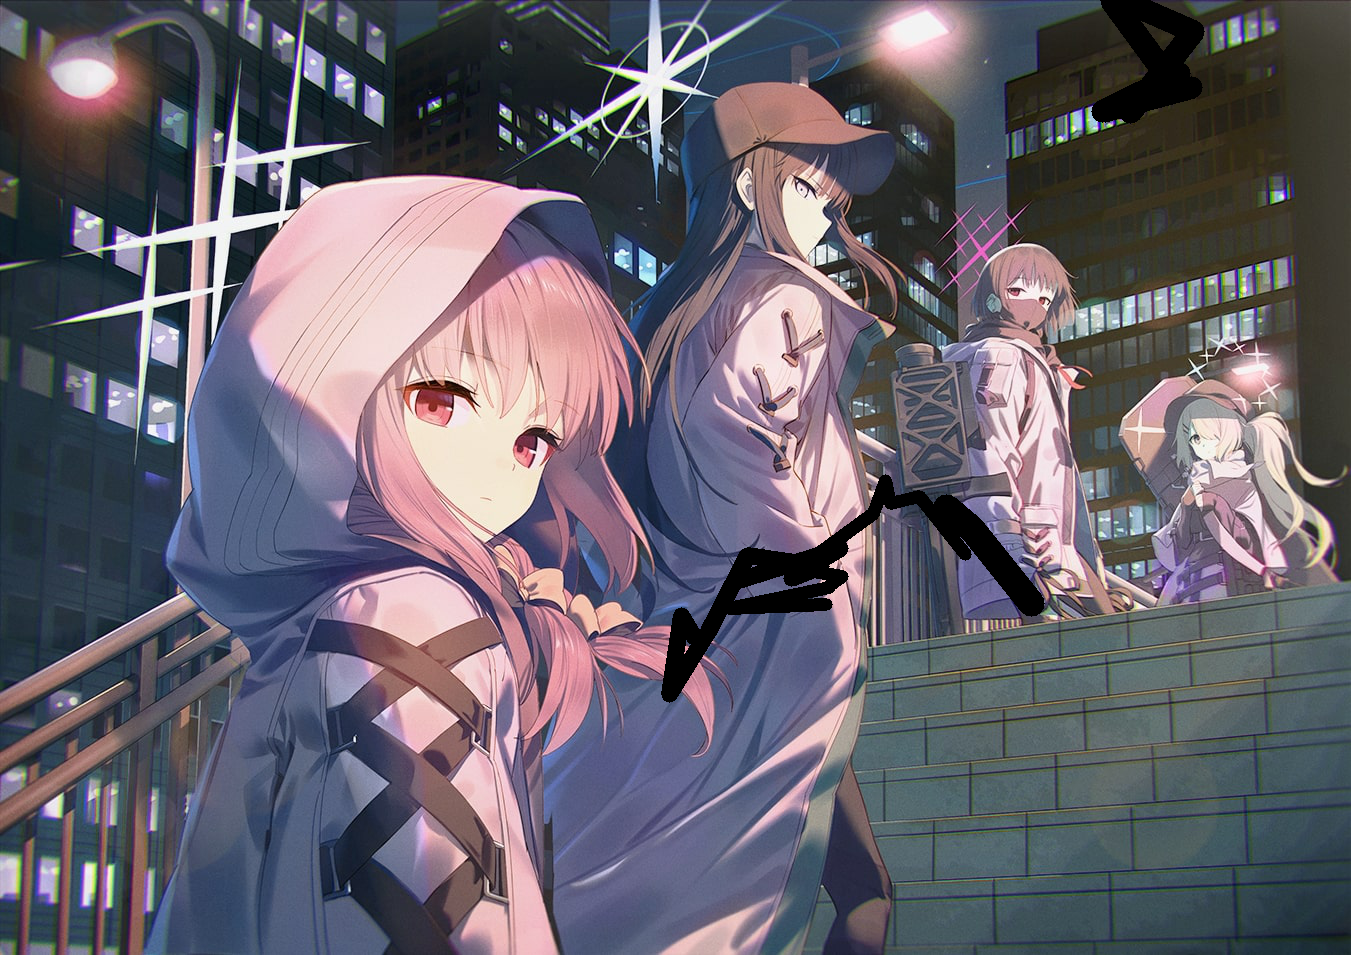

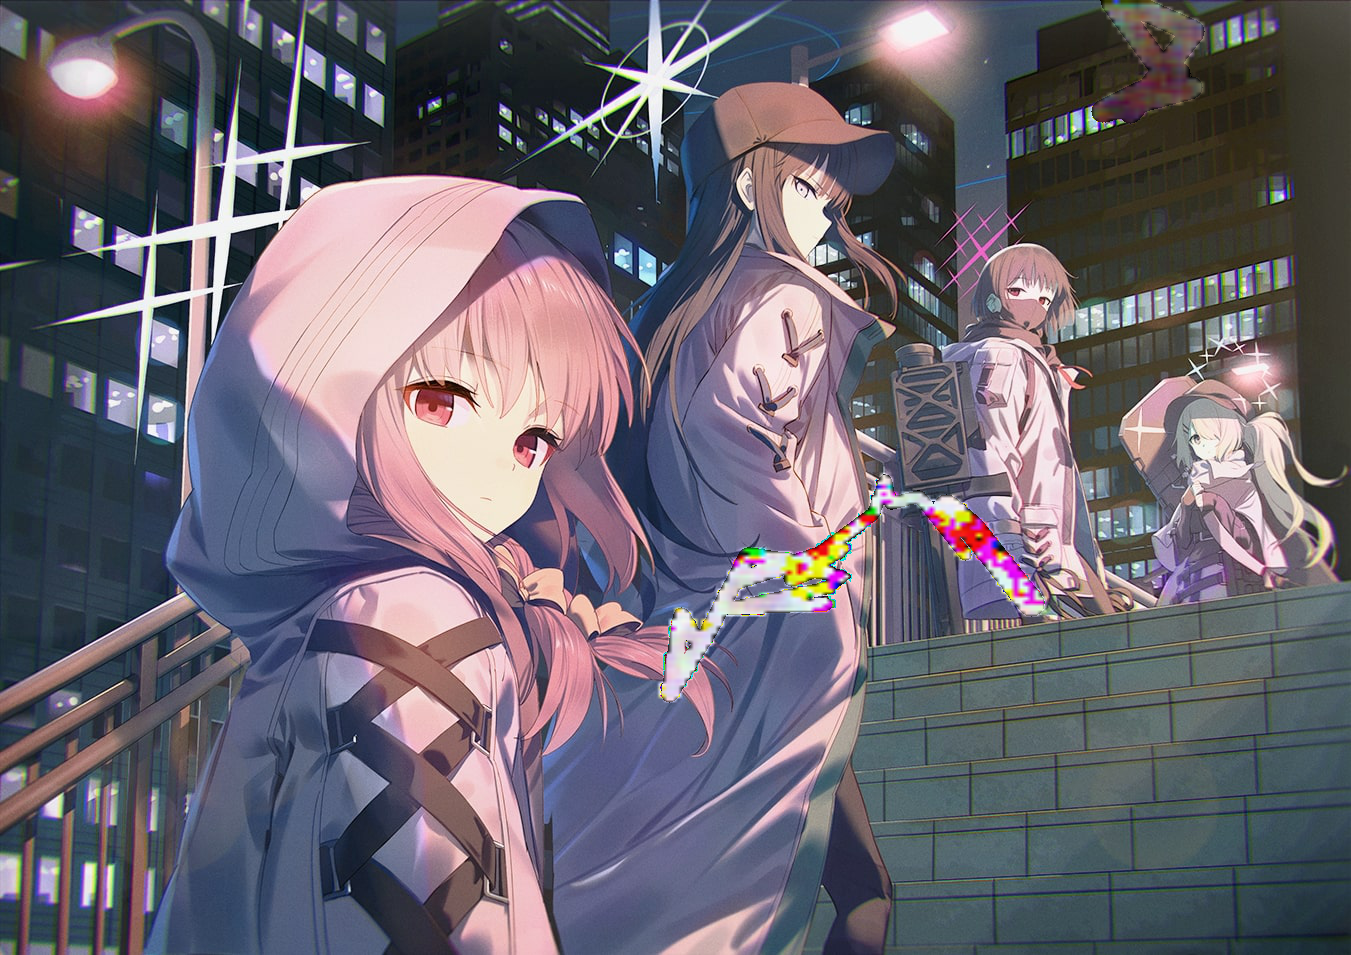

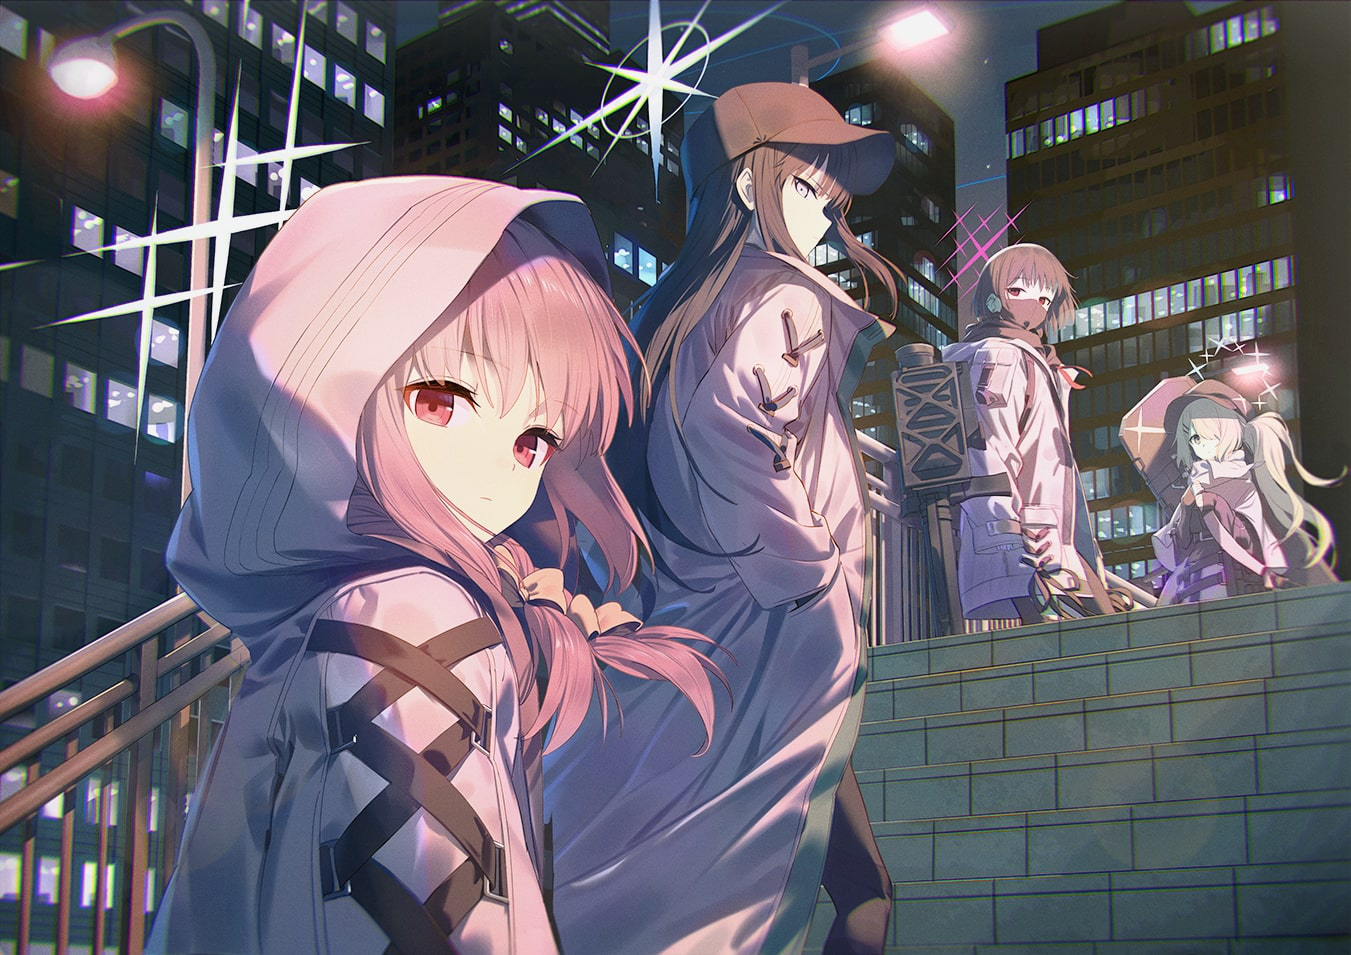

In [109]:
#Test 1 input
device = 'cuda'

coarse_model = CoarseNet().to(device)
super_resolution_model = SuperResolutionNet().to(device)
refinement_model = RefinementNet(use_gpu = True).to(device)

coarse_model.load_state_dict(torch.load('/home/nakere424/anime_inpainting/save_model/coarse_model_1000.pt'))
super_resolution_model.load_state_dict(torch.load('/home/nakere424/anime_inpainting/save_model/super_resolution_model_2500.pt'))
refinement_model.load_state_dict(torch.load('/home/nakere424/anime_inpainting/save_model/refinement_model_1000.pt'))

original_image = cv2.imread('/home/nakere424/anime_inpainting/Input/Blue.Archive.full.3587004.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

original_image_shape = (original_image.shape[0], original_image.shape[1])

original_masked_image, original_mask = mask_image(np.array(original_image), 1, 4)

masked_image, mask = cv2.resize(original_masked_image, (256, 256)), cv2.resize(original_mask, (256, 256))

masked_image = preprocess(masked_image).unsqueeze(0)
mask = torch.permute(torch.tensor(mask, dtype = torch.float32), (2, 0, 1)).unsqueeze(0)

with torch.no_grad():
    masked_image, mask = masked_image.to(device), mask.to(device)

    coarse_output = coarse_model(masked_image, mask)
    coarse_output = (mask*coarse_output) + masked_image
    
#     super_resolution_output = super_resolution_model(coarse_output)
    
#     mask = F.interpolate(mask, scale_factor=2, mode='nearest')
#     refinement_output = refinement_model(super_resolution_output, mask)
    
#     output = postprocess(refinement_output.cpu())[0]
    mask = torch.permute(mask.cpu(), (0, 2, 3, 1))[0].numpy()
#     masked_image = postprocess(masked_image.cpu())[0]
    output = postprocess(coarse_output.cpu())[0]
    
output = output * mask
output = cv2.resize(output , (original_image_shape[1], original_image_shape[0]))
output = original_masked_image + output
output = output.astype('uint8')

masked_image = Image.fromarray(original_masked_image)
display(masked_image)
output = Image.fromarray(output)
display(output)
original_image = Image.fromarray(original_image)
display(original_image)